In [1]:
import cv2

from scipy import signal
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import glob
import natsort
import cs

In [2]:
def create_skin_mask(img):
    mask = None
    # 얼굴영역 검출 (피부픽셀 검출)
    try:
        low = np.array([0, 133, 77], np.uint8)
        high = np.array([235, 173, 127], np.uint8)
        
        # 얼굴 box를 찾은 후에 피부픽셀만 분리하는 함수 (실시간성을 고려하지 않으면 다른 모델로 대체 가능)
        ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        mask = cv2.inRange(ycrcb, low, high)
        mask[mask == 255] = 1
    except Exception:
        pass

    return mask

def detrend_signal(arr, win_size):
    # 신호 후처리 함수 (detrend = 추세 를 없앤다.)
    #심박과 관련없는 저주파 와 같은 추세를 없애는 것
    try:
        if arr.ndim == 1:
            arr = np.expand_dims(arr, axis=0)
        n_channel = arr.shape[0]
        norm = signal.convolve2d(np.ones_like(arr), np.ones((n_channel, win_size)), mode='same')
        mean = signal.convolve2d(arr, np.ones((n_channel, win_size)), mode='same') / norm
        return (arr - mean) / (mean + 1e-15)
    except ValueError:
        return arr

def filter_bandpass(arr, srate, band):
    #대역통과필터
    try:
        # 심박수(bpm)의 주파수 도메인은 HZ , 따라서 60을 곱해야 초당이 아닌 분당으로 계산
        nyq = 60 * srate / 2
        coef_vector = signal.butter(5, [band[0] / nyq, band[1] / nyq], 'bandpass')
        return signal.filtfilt(*coef_vector, arr)
    except ValueError:
        return arr
    
def estimate_average_pulserate(arr, srate):
    # 후처리가 완료된 데이터로ㅓ 맥박수 측정
    f, pxx = signal.periodogram(arr, fs=srate, window='hann')
    # 가장 쎈 대역? 주파수 를 찾는다. >> 분당으로 환산한것이 pulserate
    max_peak_idx = np.argmax(pxx)
    pulserate = int(f[max_peak_idx] * 60)
    return min(max(pulserate, band[0]), band[1])

# Rppg 신호측정

## 1. Face
- 이미지로 부터 RPPG 신호 측정

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1_0.0.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2_0.03333329999446869.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3_0.06666669994592667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4_0.1.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5_0.1333332999944687.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_6_0.16666669994592667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_7_0.2.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_8_0.2333332999944687.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_9_0.2666666999459267.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_10_0.3.png
(

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_84_2.766666699945927.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_85_2.8000000000000003.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_86_2.833333299994469.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_87_2.866666699945927.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_88_2.9.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_89_2.9333332999944686.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_90_2.9666666999459266.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_91_3.0.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_92_3.0333332999944687.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Det

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_164_5.433333299994469.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_165_5.466666699945927.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_166_5.5.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_167_5.533333299994469.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_168_5.566666699945927.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_169_5.6000000000000005.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_170_5.633333299994469.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_171_5.666666699945927.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_172_5.7.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\im

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_243_8.066666699945927.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_244_8.1.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_245_8.133333299994469.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_246_8.166666699945926.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_247_8.2.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_248_8.233333299994468.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_249_8.266666699945926.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_250_8.3.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_251_8.333333299994468.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_252

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_322_10.700000000000001.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_323_10.733333299994468.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_324_10.766666699945928.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_325_10.8.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_326_10.833333299994468.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_327_10.866666699945927.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_328_10.9.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_329_10.93333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_330_10.966666699945927.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_400_13.3.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_401_13.33333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_402_13.366666699945927.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_403_13.4.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_404_13.43333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_405_13.466666699945927.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_406_13.5.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_407_13.533333299994469.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_408_13.566666699945927.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_482_16.033333299994467.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_483_16.066666699945927.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_484_16.1.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_485_16.13333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_486_16.166666699945928.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_487_16.2.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_488_16.23333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_489_16.266666699945926.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_490_16.3.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_564_18.766666699945926.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_565_18.8.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_566_18.833333299994468.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_567_18.866666699945927.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_568_18.900000000000002.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_569_18.93333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_570_18.96666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_571_19.0.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_572_19.033333299994467.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_642_21.366666699945927.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_643_21.400000000000002.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_644_21.43333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_645_21.46666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_646_21.5.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_647_21.53333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_648_21.566666699945927.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_649_21.6.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_650_21.63333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detectio

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_724_24.1.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_725_24.13333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_726_24.166666699945928.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_727_24.2.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_728_24.23333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_729_24.266666699945926.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_730_24.3.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_731_24.333333299994468.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_732_24.366666699945927.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_805_26.8.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_806_26.833333299994468.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_807_26.866666699945927.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_808_26.900000000000002.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_809_26.93333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_810_26.96666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_811_27.0.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_812_27.03333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_813_27.066666699945927.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detecti

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_885_29.46666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_886_29.5.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_887_29.53333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_888_29.566666699945927.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_889_29.6.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_890_29.63333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_891_29.666666699945928.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_892_29.7.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_893_29.73333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detecti

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_965_32.13333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_966_32.16666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_967_32.2.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_968_32.23333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_969_32.26666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_970_32.3.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_971_32.33333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_972_32.366666699945924.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_973_32.4.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detectio

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1045_34.800000000000004.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1046_34.83333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1047_34.86666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1048_34.9.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1049_34.933333299994466.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1050_34.966666699945925.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1051_35.0.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1052_35.03333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1053_35.06666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rpp

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1124_37.43333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1125_37.466666699945925.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1126_37.5.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1127_37.53333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1128_37.56666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1129_37.6.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1130_37.63333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1131_37.66666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1132_37.7.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1202_40.03333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1203_40.06666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1204_40.1.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1205_40.13333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1206_40.16666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1207_40.2.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1208_40.23333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1209_40.26666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1210_40.300000000000004.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1280_42.63333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1281_42.66666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1282_42.7.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1283_42.73333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1284_42.76666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1285_42.800000000000004.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1286_42.83333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1287_42.86666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1288_42.9.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1358_45.23333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1359_45.26666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1360_45.300000000000004.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1361_45.33333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1362_45.36666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1363_45.4.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1364_45.43333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1365_45.466666699945925.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1366_45.5.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1438_47.9.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1439_47.93333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1440_47.966666699945925.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1441_48.0.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1442_48.03333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1443_48.06666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1444_48.1.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1445_48.13333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1446_48.16666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\imag

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1518_50.56666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1519_50.6.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1520_50.63333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1521_50.66666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1522_50.7.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1523_50.73333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1524_50.76666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1525_50.800000000000004.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1526_50.83333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1596_53.16666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1597_53.2.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1598_53.23333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1599_53.26666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1600_53.300000000000004.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1601_53.33333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1602_53.36666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1603_53.4.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1604_53.43333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_D

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1677_55.86666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1678_55.9.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1679_55.93333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1680_55.966666699945925.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1681_56.0.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1682_56.03333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1683_56.06666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1684_56.1.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1685_56.13333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1758_58.56666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1759_58.6.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1760_58.63333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1761_58.66666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1762_58.7.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1763_58.73333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1764_58.76666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1765_58.800000000000004.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1766_58.83333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_D

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1839_61.26666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1840_61.300000000000004.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1841_61.33333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1842_61.36666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1843_61.4.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1844_61.43333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1845_61.466666699945925.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1846_61.5.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1847_61.53333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1921_64.0.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1922_64.03333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1923_64.06666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1924_64.1.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1925_64.13333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1926_64.16666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1927_64.2.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1928_64.23333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1929_64.26666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2003_66.73333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2004_66.76666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2005_66.8.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2006_66.83333329999446.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2007_66.86666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2008_66.9.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2009_66.93333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2010_66.96666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2011_67.0.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2082_69.36666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2083_69.4.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2084_69.43333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2085_69.46666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2086_69.5.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2087_69.53333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2088_69.56666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2089_69.60000000000001.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2090_69.63333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_De

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2161_72.0.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2162_72.03333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2163_72.06666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2164_72.10000000000001.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2165_72.13333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2166_72.16666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2167_72.2.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2168_72.23333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2169_72.26666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_De

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2239_74.60000000000001.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2240_74.63333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2241_74.66666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2242_74.7.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2243_74.73333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2244_74.76666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2245_74.8.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2246_74.83333329999446.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2247_74.86666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_De

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2317_77.2.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2318_77.23333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2319_77.26666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2320_77.3.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2321_77.33333329999446.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2322_77.36666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2323_77.4.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2324_77.43333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2325_77.46666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2398_79.9.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2399_79.93333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2400_79.96666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2401_80.0.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2402_80.03333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2403_80.06666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2404_80.10000000000001.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2405_80.13333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2406_80.16666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\R

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2476_82.5.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2477_82.53333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2478_82.56666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2479_82.60000000000001.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2480_82.63333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2481_82.66666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2482_82.7.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2483_82.73333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2484_82.76666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_De

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2554_85.10000000000001.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2555_85.13333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2556_85.16666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2557_85.2.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2558_85.23333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2559_85.26666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2560_85.3.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2561_85.33333329999446.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2562_85.36666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_De

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2634_87.76666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2635_87.8.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2636_87.83333329999446.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2637_87.86666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2638_87.9.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2639_87.93333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2640_87.96666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2641_88.0.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2642_88.03333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2715_90.46666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2716_90.5.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2717_90.53333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2718_90.56666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2719_90.60000000000001.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2720_90.63333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2721_90.66666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2722_90.7.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2723_90.73333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_De

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2796_93.16666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2797_93.2.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2798_93.23333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2799_93.26666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2800_93.3.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2801_93.33333329999446.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2802_93.36666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2803_93.4.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2804_93.43333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2875_95.8.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2876_95.83333329999446.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2877_95.86666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2878_95.9.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2879_95.93333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2880_95.96666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2881_96.0.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2882_96.03333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2883_96.06666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2953_98.4.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2954_98.43333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2955_98.46666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2956_98.5.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2957_98.53333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2958_98.56666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2959_98.60000000000001.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2960_98.63333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2961_98.66666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_De

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3031_101.0.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3032_101.03333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3033_101.06666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3034_101.10000000000001.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3035_101.13333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3036_101.16666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3037_101.2.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3038_101.23333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3039_101.26666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\y

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3108_103.56666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3109_103.60000000000001.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3110_103.63333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3111_103.66666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3112_103.7.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3113_103.73333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3114_103.76666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3115_103.8.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3116_103.83333329999446.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-De

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3186_106.16666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3187_106.2.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3188_106.23333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3189_106.26666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3190_106.3.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3191_106.33333329999446.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3192_106.36666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3193_106.4.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3194_106.43333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3264_108.76666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3265_108.8.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3266_108.83333329999446.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3267_108.86666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3268_108.9.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3269_108.93333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3270_108.96666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3271_109.0.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3272_109.03333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3345_111.46666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3346_111.5.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3347_111.53333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3348_111.56666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3349_111.60000000000001.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3350_111.63333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3351_111.66666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3352_111.7.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3353_111.73333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\y

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3424_114.10000000000001.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3425_114.13333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3426_114.16666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3427_114.2.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3428_114.23333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3429_114.26666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3430_114.3.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3431_114.33333329999446.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3432_114.36666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-De

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3502_116.7.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3503_116.73333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3504_116.76666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3505_116.8.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3506_116.83333329999446.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3507_116.86666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3508_116.9.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3509_116.93333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3510_116.96666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detect

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3583_119.4.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3584_119.43333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3585_119.46666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3586_119.5.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3587_119.53333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3588_119.56666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3589_119.60000000000001.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3590_119.63333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3591_119.66666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-De

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3660_121.96666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3661_122.0.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3662_122.03333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3663_122.06666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3664_122.10000000000001.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3665_122.13333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3666_122.16666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3667_122.2.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3668_122.23333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-De

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3741_124.66666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3742_124.7.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3743_124.73333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3744_124.76666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3745_124.8.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3746_124.83333329999446.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3747_124.86666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3748_124.9.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3749_124.93333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3820_127.3.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3821_127.33333329999446.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3822_127.36666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3823_127.4.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3824_127.43333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3825_127.46666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3826_127.5.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3827_127.53333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3828_127.56666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3898_129.9.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3899_129.93333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3900_129.96666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3901_130.0.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3902_130.03333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3903_130.06666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3904_130.1.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3905_130.13333329999446.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3906_130.16666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3979_132.6.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3980_132.63333329999446.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3981_132.66666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3982_132.7.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3983_132.73333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3984_132.76666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3985_132.8.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3986_132.83333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3987_132.86666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detect

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4059_135.26666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4060_135.3.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4061_135.33333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4062_135.36666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4063_135.4.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4064_135.43333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4065_135.46666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4066_135.5.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4067_135.53333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4141_138.0.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4142_138.03333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4143_138.06666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4144_138.1.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4145_138.13333329999446.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4146_138.16666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4147_138.20000000000002.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4148_138.23333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4149_138.26666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\y

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4218_140.56666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4219_140.6.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4220_140.63333329999446.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4221_140.66666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4222_140.70000000000002.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4223_140.73333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4224_140.76666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4225_140.8.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4226_140.83333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-De

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4299_143.26666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4300_143.3.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4301_143.33333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4302_143.36666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4303_143.4.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4304_143.43333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4305_143.46666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4306_143.5.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4307_143.53333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detect

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4376_145.83333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4377_145.86666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4378_145.9.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4379_145.93333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4380_145.96666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4381_146.0.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4382_146.03333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4383_146.06666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4384_146.1.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detect

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4454_148.43333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4455_148.46666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4456_148.5.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4457_148.53333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4458_148.56666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4459_148.6.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4460_148.63333329999446.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4461_148.66666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4462_148.70000000000002.png
(1, 1, 200, 7)
img path:  D:\prlab\y

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4532_151.03333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4533_151.06666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4534_151.1.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4535_151.13333329999446.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4536_151.16666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4537_151.20000000000002.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4538_151.23333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4539_151.26666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4540_151.3.png
(1, 1, 200, 7)
img path:  D:\prlab\y

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4609_153.6.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4610_153.63333329999446.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4611_153.66666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4612_153.70000000000002.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4613_153.73333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4614_153.76666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4615_153.8.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4616_153.83333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4617_153.86666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\y

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4686_156.16666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4687_156.20000000000002.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4688_156.23333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4689_156.26666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4690_156.3.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4691_156.33333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4692_156.36666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4693_156.4.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4694_156.43333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-De

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4766_158.83333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4767_158.86666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4768_158.9.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4769_158.93333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4770_158.96666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4771_159.0.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4772_159.03333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4773_159.06666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4774_159.1.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4844_161.43333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4845_161.46666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4846_161.5.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4847_161.53333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4848_161.56666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4849_161.6.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4850_161.63333329999446.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4851_161.66666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4852_161.70000000000002.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-De

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4921_164.0.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4922_164.03333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4923_164.06666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4924_164.1.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4925_164.13333329999446.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4926_164.16666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4927_164.20000000000002.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4928_164.23333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4929_164.26666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\y

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4999_166.6.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5000_166.63333329999446.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5001_166.66666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5002_166.70000000000002.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5003_166.73333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5004_166.76666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5005_166.8.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5006_166.83333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5007_166.86666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-De

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5078_169.23333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5079_169.26666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5080_169.3.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5081_169.33333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5082_169.36666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5083_169.4.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5084_169.43333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5085_169.46666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5086_169.5.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5155_171.8.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5156_171.83333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5157_171.86666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5158_171.9.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5159_171.93333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5160_171.96666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5161_172.0.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5162_172.03333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5163_172.06666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5236_174.5.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5237_174.53333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5238_174.56666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5239_174.6.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5240_174.63333329999446.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5241_174.66666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5242_174.70000000000002.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5243_174.73333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5244_174.76666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-De

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5314_177.1.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5315_177.13333329999446.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5316_177.16666669994592.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5317_177.20000000000002.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5318_177.23333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5319_177.26666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5320_177.3.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5321_177.33333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5322_177.36666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-De

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5395_179.8.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5396_179.83333329999448.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5397_179.86666669994594.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5398_179.9.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5399_179.93333329999447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5400_179.96666669994593.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5401_180.0.png
(1, 1, 200, 7)
==================================================!!!finish!!!=================================================


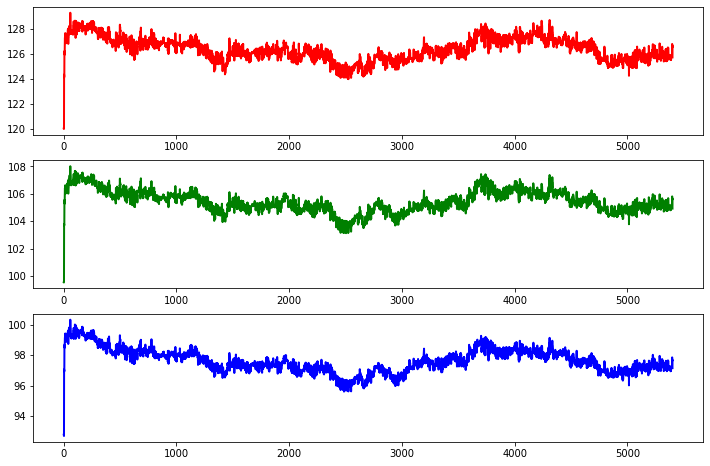

In [19]:
band = [42, 240]
fps = 30

r_signal = []
g_signal = []
b_signal = []
prev_bbox = [0,0,10,10]
curr_bbox = [0,0,10,10]
track_toler = 1
detect_th=0.5
# 얼굴검출 opencv 사용 
detector = cv2.dnn.readNetFromTensorflow('model/face_detector.pb',
                                         'model/face_detector.pbtxt')

times=[]
group=[]

#cap = cv2.VideoCapture(1) # 0: 내장캠 1: 외부캠
#time.sleep(2)

subject=1
file_path="D:\\prlab\\ysg\\rppg\\RPPG-Deepfake_Detection\\image\\"+str(subject)+"\\"
file_list=glob.glob(os.path.join(file_path,"*.png"))
file_list = natsort.natsorted(file_list,reverse=False)

try:
    for file in file_list:
        # group 설정
        g=file.split('\\')[-1].split('_')[1]
        group.append(g)
        # time 설정
        t=file.split('\\')[-1].split('_')[-1][:-4]
        times.append(t)
        # 프레임(img) 가져오기
        print("img path: ",file)
        frame = cv2.imread(file, cv2.IMREAD_COLOR)

        # 현재 프레임에서 얼굴 검출하기
        blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), [104., 117., 123.], False, False)
        detector.setInput(blob)
        detections = detector.forward()
        print(detections.shape)

        h, w = frame.shape[:2]
        bboxes = [detections[0, 0, i, 3:7] for i in range(detections.shape[2]) if detections[0, 0, i, 2] >= detect_th]
        if len(bboxes) > 0:
            # bbox가 존재한다면!
            bboxes = sorted(bboxes, key=lambda x: (x[2] - x[0]) * (x[3] - x[1]), reverse=True)
            bboxes = [(rect * np.array([w, h, w, h])).astype('int') for rect in bboxes]  # (xs,ys,xe,ye)
            curr_bbox = bboxes[0] # 얼굴 위치
            prev_bbox = curr_bbox
        else:
            # 존재하지 않는다면 즉, 얼굴 검출이 잘 안됐다면
            curr_bbox = prev_box

        # 얼굴 영역만 잘라내기
        face = frame[curr_bbox[1]:curr_bbox[3], curr_bbox[0]:curr_bbox[2]]

        # remote-PPG 신호 추출하기
        b, g, r = cv2.split(face)
        r_mean = np.mean(r)
        g_mean = np.mean(g)
        b_mean = np.mean(b)
        # 각신호를 담을 list
        r_signal.append(r_mean)
        g_signal.append(g_mean)
        b_signal.append(b_mean)

        # 얼굴 검출 시각화하기
        cv2.rectangle(frame, (curr_bbox[0], curr_bbox[1]), (curr_bbox[2], curr_bbox[3]), (0,0,255), 2)
        cv2.imshow('frame', frame)
        if cv2.waitKey(1) == 27:
            break
            
    
finally:
    cv2.destroyAllWindows()
    print("==================================================!!!finish!!!=================================================")

plt.figure(figsize=(12, 8))
plt.subplot(3,1,1)
plt.plot(r_signal, 'r', linewidth=2)
plt.subplot(3,1,2)
plt.plot(g_signal, 'g', linewidth=2)
plt.subplot(3,1,3)
plt.plot(b_signal, 'b', linewidth=2)
plt.show()

pulse length:  (5401,)


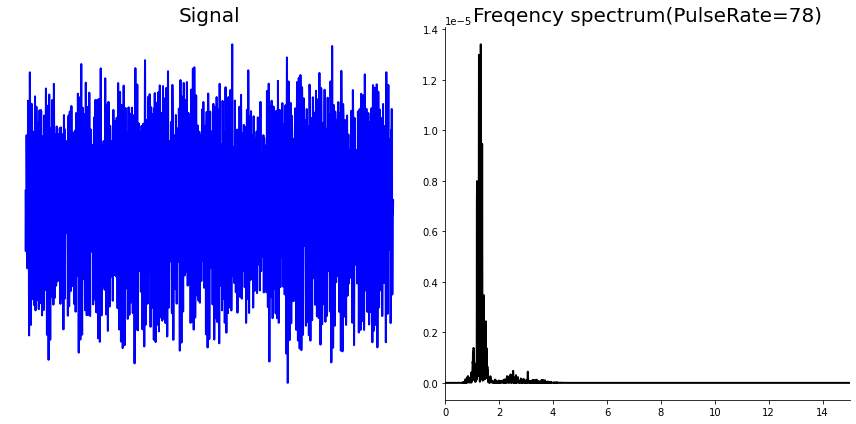

In [20]:
# CHROM 신호 추출
# chrom이란 움직임에 더 강인하게 하는것.
# 움직임은 r,g,b동일하게발생/ pulse는 r,g,b각각 다름
# 이를 이용해 움직임은 제거하고 pulse만 남기도록.

#보통 신호는 g,r,b순으로 잘보인다. 
# 심박수를 더 잘보이게 하기위한 후처리
raw_signal = np.array([r_signal, g_signal, b_signal]).transpose() # 1.세개의 신호를 하나로, 하나의신호화
detrended = detrend_signal(raw_signal, fps) # 2.추세제거
detrended = detrended.transpose()
# 3. 2차원으로 prediction  , 수식에 대해서는 자세히 이해 x
X = 3 * detrended[0] - 2 * detrended[1] # 4. detrend [] > 0: r, 1: g, 2: b
Y = 1.5 * detrended[0] + detrended[1] - 1.5 * detrended[2]
# 5. bandpass filtering
Xf = filter_bandpass(X, fps, band)
Yf = filter_bandpass(Y, fps, band)
alpha = np.std(Xf) / np.std(Yf)
# 6. pulse 신호로 계산
pulse = Xf - alpha * Yf
print("pulse length: ",pulse.shape)

# 심박수 (심장) / '맥박수' (혈관) >> 우리는 맥박수를 보는것.
# 맥박수 계산하는 방법
# 1) 시계열 도메인에서 PPI(peak-to-peak interval) 계산  ==> instant pulse-rate
# 2) 주파수 도메인에서 maximum power band 검출 ==> average pulse-rate


# 주파수 스펙트럼 계산
# 실시간에서는 실시간 fs를 계산해서 파라미터로 넣어줘야함
f, psd = signal.periodogram(pulse, fs=30, window='hann')
max_band = np.argmax(psd)
pr = int(f[max_band] * 60) #분당맥박수
pr = min(max(pr, band[0]), band[1])


plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(pulse, 'b', linewidth=2)    
plt.axis('off')
plt.title('Signal', fontsize=20)

ax = plt.subplot(1,2,2)
plt.plot(f, psd, 'k', linewidth=2)    
plt.xlim([0, 15])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Freqency spectrum(PulseRate={})'.format(pr), fontsize=20)

plt.tight_layout()
plt.show()

# file_num=subject
# save_path='D:\\prlab\\ysg\\rppg\\rppg_HRV\\data\\rppg\\'
# f = open(save_path+'rppg'+str(file_num)+'.csv', 'w', newline='')
# wr = csv.writer(f)
# wr.writerow(pulse)
# wr.writerow(times)
# wr.writerow(group)
# f.close()

In [21]:
face_pulse=pulse

## 2. ARM RPPG

## 팔영역검출

#### 1. ycbcr로 피부영역검출

In [92]:
# frame = cv2.imread("./WIN_20210722_16_40_08_Pro.jpg", cv2.IMREAD_COLOR)
# ycbcr_frame=cv2.cvtColor(frame,cv2.COLOR_BGR2YCR_CB)
# lower = np.array([0,150,50], dtype="uint8")
# upper = np.array([255,173,127], dtype="uint8")
# skin_img = cv2.inRange(ycbcr_frame, lower, upper)
# print(skin_img.shape)
# img_hand=skin_img
# print(img_hand)
# for i in range(skin_img.shape[0]):
#     for j in range(skin_img.shape[1]):
#         if img_hand[i][j]==255:
#             if 550<=j<=750 and 0<=i<=350 :
#                 img_hand[i][j]=0
#                 print("i,j",img_hand[i][j])
                
# cv2.rectangle(img_hand, (750,350), (550, 180), (255,0,0), 2)
# cv2.imshow('img',img_hand)
# cv2.imshow('skinimg',skin_img)
# while True :
#     if cv2.waitKey(0) == 27 :
#         cv2.destroyWindow('img')
#         cv2.destroyWindow('skinimg')
#         break;

#### 2. YCBCR에서 fill flood 알고리즘을 사용하여 팔영역만 추출

In [19]:
#ycbcr
def fill(data, start_coords, fill_value):

    xsize= data.shape[0]
    ysize=data.shape[1]
    orig_CR = data[start_coords[0], start_coords[1]][1]
    orig_CB = data[start_coords[0], start_coords[1]][2] 
    #print("orig",orig_CR, orig_CB) # Y, CR, CB
    stack = set(((start_coords[0], start_coords[1]),))
    
    if fill_value[0] == orig_CR and fill_value[1] == orig_CB:
        raise ValueError("Filling region with same value "
                     "already present is unsupported. "
                     "Did you already fill this region?")

    while stack:
        x, y = stack.pop()
        CR=data[x, y][1]
        CB=data[x, y][2]
        if 130<=CR<=173 and 50<=CB<=127:
            #print('fill_x: ',x,'fill_y: ',y)
            
            ROI_x.append(x)
            ROI_y.append(y)
            
            data[x, y][1] = fill_value[0]
            data[x, y][2] = fill_value[1]
            if x > 0:
                stack.add((x - 1, y))
            if x < (xsize - 1):
                stack.add((x + 1, y))
            if y > 0:
                stack.add((x, y - 1))
            if y < (ysize - 1):
                stack.add((x, y + 1))
    data=cv2.rectangle(data,(min(ROI_y),min(ROI_x)),(max(ROI_y),max(ROI_x)),(0,0,255),3)
    cv2.imshow('fill',data)
    return ROI_x,ROI_y

def click_event(event, x, y, flags, param):
    global ROI_x,ROI_y
    if event == cv2.EVENT_LBUTTONDOWN:
        ROI_x=[]
        ROI_y=[]
        #print('x: ',x,'y: ',y)
        print(ycbcr_frame[y][x],frame[y][x])
        ROI_x,ROI_y=fill(ycbcr_frame,[y,x],[0,0]) # BGR
        
def find_arm(y_crcb_img):
    cv2.namedWindow('image')
    cv2.setMouseCallback('image',click_event)

    while(1):
        cv2.imshow('image',y_crcb_img)
        if cv2.waitKey(0) == 27 :
            break
    cv2.destroyAllWindows()

    
file_num=1    
file_path="D:\\prlab\\ysg\\rppg\\RPPG-Deepfake_Detection\\image\\"+str(file_num)+"\\"
save_path="D:\\prlab\\ysg\\rppg\\RPPG-Deepfake_Detection\\ROI\\"+str(file_num)+"\\"

file_list=glob.glob(os.path.join(file_path,"*.png"))
file_list = natsort.natsorted(file_list,reverse=False)

frame = cv2.imread(file_list[0], cv2.IMREAD_COLOR)
ycbcr_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2YCR_CB)
# 1. 팔영역 ROI찾기
find_arm(ycbcr_frame)
# ROI 이미지 크롭, 팔빼고 black처리
ROI=list(zip(ROI_x,ROI_y))
for i in range(min(ROI_x),max(ROI_x),1):
    for j in range(min(ROI_y),max(ROI_y),1):
        if (i,j)not in ROI:
            frame[i][j]=0

arm=frame[min(ROI_x):max(ROI_x)+1,min(ROI_y):max(ROI_y)+1]
kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
arm=cv2.erode(arm,kernel)
arm=cv2.erode(arm,kernel)
arm_=cv2.erode(arm,kernel)
arm=cv2.dilate(arm,None)
arm=cv2.dilate(arm,None)
arm=cv2.dilate(arm,None)
cv2.imwrite(save_path+str(0)+'.png',arm)

# 팔검출 확인
for (n,file) in enumerate(file_list):
    if n>0:
        print('file_num:',n)
        frame = cv2.imread(file, cv2.IMREAD_COLOR)
#         ycbcr_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2YCR_CB)
        # 1. 팔영역 ROI찾기
#        find_arm(ycbcr_frame)
        # ROI 이미지 크롭, 팔빼고 black처리
#        ROI=list(zip(ROI_x,ROI_y))
        for i in range(min(ROI_x),max(ROI_x),1):
            for j in range(min(ROI_y),max(ROI_y),1):
                if (i,j)not in ROI:
                    frame[i][j]=0

        arm=frame[min(ROI_x):max(ROI_x)+1,min(ROI_y):max(ROI_y)+1]
        cv2.imshow('arm',arm)
        cv2.imwrite(save_path+str(n)+'.png',arm)
#        while(1):
        
#         if cv2.waitKey(0) == 27 :
#             break
cv2.destroyAllWindows()

[248 133 116] [227 249 255]
file_num: 1
file_num: 2
file_num: 3
file_num: 4
file_num: 5
file_num: 6
file_num: 7


KeyboardInterrupt: 

#### 3. 마우스로 ROI 직접 지정.

In [11]:
def click_event(event, x, y, flags, param):
    global xmin, ymin,xmax,ymax, drawing, img, ROI_img, drawing_flag

    if event == cv2.EVENT_LBUTTONDOWN:  # 마우스를 누른 상태
        drawing = True
        xmin, ymin = x, y

    elif event == cv2.EVENT_MOUSEMOVE:  # 마우스 이동
        if drawing == True:  # 마우스를 누른 상태 일경우
            img_temp = img.copy()
            cv2.rectangle(img_temp, (xmin, ymin), (x, y), (0, 0, 255), 1)
            cv2.imshow('image', img_temp)

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False  # 마우스를 때면 상태 변경
        xmax,ymax=x,y
        cv2.rectangle(img, (xmin, ymin), (x, y), (0, 0, 255), 1)
        cv2.imshow('image', img)
        ROI_img=img[ymin+1:y,xmin+1:x]
        cv2.imshow('ROI img',ROI_img)
        print('xmin :{}, ymin:{}, xmax:{}, ymax:{}'.format(xmin, ymin, x, y))
        drawing_flag = True
        
def find_arm(img):
    cv2.namedWindow('image')
    cv2.setMouseCallback('image',click_event)

    while(1):
        cv2.imshow('image',img)
        if cv2.waitKey(0) == 27 :
            break
    cv2.destroyAllWindows()

    

file_num=1    
file_path="D:\\prlab\\ysg\\rppg\\RPPG-Deepfake_Detection\\image\\"+str(file_num)+"\\"
save_path="D:\\prlab\\ysg\\rppg\\RPPG-Deepfake_Detection\\ROI\\"+str(file_num)+"\\"

file_list=glob.glob(os.path.join(file_path,"*.png"))
file_list = natsort.natsorted(file_list,reverse=False)

drawing=False
img = cv2.imread(file_list[0], cv2.IMREAD_COLOR)
find_arm(img)
cv2.imwrite(save_path+'0.png',ROI_img)
for (i,file) in enumerate(file_list):
    if i>0:
        print("file_name",file)
        img = cv2.imread(file, cv2.IMREAD_COLOR)
        ROI_img=img[ymin+1:ymax,xmin+1:xmax]
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 1)
        cv2.imshow('img',img)
        cv2.imwrite(save_path+str(i)+'.png',ROI_img)
        if cv2.waitKey(1) == 27:
            break
cv2.destroyAllWindows()

xmin :390, ymin:170, xmax:502, ymax:367
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2_0.03333329999446869.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3_0.06666669994592667.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4_0.1.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5_0.1333332999944687.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_6_0.16666669994592667.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_7_0.2.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_8_0.2333332999944687.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_9_0.2666666999459267.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_10_0.3.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_11_0.3333332999944687.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_12_0.36666669994592666.p

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_95_3.1333332999944687.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_96_3.1666666999459268.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_97_3.2.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_98_3.233333299994469.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_99_3.266666699945927.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_100_3.3000000000000003.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_101_3.333333299994469.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_102_3.366666699945927.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_103_3.4.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_104_3.4333332999944686.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_105_3.4666666999459266.png
file_name D:\prl

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_191_6.333333299994469.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_192_6.3666666999459265.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_193_6.4.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_194_6.433333299994469.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_195_6.466666699945927.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_196_6.5.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_197_6.533333299994469.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_198_6.566666699945927.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_199_6.6000000000000005.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_200_6.633333299994469.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_201_6.666666699945927.png
file_name D:\p

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_284_9.43333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_285_9.466666699945927.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_286_9.5.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_287_9.533333299994469.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_288_9.566666699945927.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_289_9.6.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_290_9.633333299994469.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_291_9.666666699945926.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_292_9.700000000000001.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_293_9.733333299994468.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_294_9.766666699945928.png
file_name D:\prla

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_377_12.533333299994469.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_378_12.566666699945927.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_379_12.6.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_380_12.633333299994469.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_381_12.666666699945926.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_382_12.700000000000001.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_383_12.733333299994468.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_384_12.766666699945928.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_385_12.8.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_386_12.83333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_387_12.866666699945927.png
file_n

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_469_15.6.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_470_15.633333299994469.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_471_15.666666699945926.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_472_15.700000000000001.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_473_15.733333299994468.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_474_15.766666699945928.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_475_15.8.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_476_15.83333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_477_15.866666699945927.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_478_15.9.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_479_15.93333329999447.png
file_name D:\prlab\ys

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_563_18.73333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_564_18.766666699945926.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_565_18.8.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_566_18.833333299994468.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_567_18.866666699945927.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_568_18.900000000000002.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_569_18.93333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_570_18.96666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_571_19.0.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_572_19.033333299994467.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_573_19.066666699945927.png
file_nam

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_657_21.866666699945927.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_658_21.900000000000002.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_659_21.93333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_660_21.96666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_661_22.0.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_662_22.03333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_663_22.066666699945927.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_664_22.1.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_665_22.13333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_666_22.166666699945928.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_667_22.2.png
file_name D:\prlab\ysg\

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_752_25.03333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_753_25.066666699945927.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_754_25.1.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_755_25.13333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_756_25.166666699945928.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_757_25.2.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_758_25.23333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_759_25.266666699945926.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_760_25.3.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_761_25.333333299994468.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_762_25.366666699945927.png
file_name D:\prlab\ysg

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_846_28.166666699945928.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_847_28.2.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_848_28.23333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_849_28.266666699945926.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_850_28.3.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_851_28.333333299994468.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_852_28.366666699945927.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_853_28.400000000000002.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_854_28.43333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_855_28.46666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_856_28.5.png
file_name D:\prlab\ysg

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_942_31.366666699945927.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_943_31.400000000000002.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_944_31.43333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_945_31.46666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_946_31.5.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_947_31.53333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_948_31.566666699945927.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_949_31.6.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_950_31.63333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_951_31.666666699945928.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_952_31.7.png
file_name D:\prlab\ysg\

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1035_34.466666699945925.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1036_34.5.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1037_34.53333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1038_34.56666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1039_34.6.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1040_34.63333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1041_34.66666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1042_34.7.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1043_34.73333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1044_34.76666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1045_34.800000000000004.png
file_name D:\p

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1128_37.56666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1129_37.6.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1130_37.63333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1131_37.66666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1132_37.7.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1133_37.73333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1134_37.76666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1135_37.800000000000004.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1136_37.83333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1137_37.86666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1138_37.9.png
file_name D:\pr

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1220_40.63333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1221_40.66666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1222_40.7.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1223_40.73333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1224_40.76666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1225_40.800000000000004.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1226_40.83333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1227_40.86666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1228_40.9.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1229_40.93333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1230_40.966666699945925.png
f

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1315_43.800000000000004.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1316_43.83333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1317_43.86666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1318_43.9.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1319_43.93333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1320_43.966666699945925.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1321_44.0.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1322_44.03333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1323_44.06666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1324_44.1.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1325_44.13333329999447.png
file_name D:\p

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1410_46.966666699945925.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1411_47.0.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1412_47.03333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1413_47.06666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1414_47.1.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1415_47.13333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1416_47.16666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1417_47.2.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1418_47.23333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1419_47.26666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1420_47.300000000000004.png
file_name D:\p

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1504_50.1.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1505_50.13333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1506_50.16666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1507_50.2.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1508_50.23333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1509_50.26666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1510_50.300000000000004.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1511_50.33333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1512_50.36666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1513_50.4.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1514_50.43333329999447.png
file_name D:\pr

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1598_53.23333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1599_53.26666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1600_53.300000000000004.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1601_53.33333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1602_53.36666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1603_53.4.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1604_53.43333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1605_53.466666699945925.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1606_53.5.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1607_53.53333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1608_53.56666669994593.png
f

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1691_56.33333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1692_56.36666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1693_56.4.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1694_56.43333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1695_56.466666699945925.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1696_56.5.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1697_56.53333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1698_56.56666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1699_56.6.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1700_56.63333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1701_56.66666669994593.png
file_name D:\pr

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1784_59.43333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1785_59.466666699945925.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1786_59.5.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1787_59.53333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1788_59.56666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1789_59.6.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1790_59.63333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1791_59.66666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1792_59.7.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1793_59.73333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1794_59.76666669994593.png
file_name D:\pr

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1876_62.5.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1877_62.53333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1878_62.56666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1879_62.6.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1880_62.63333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1881_62.66666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1882_62.7.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1883_62.73333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1884_62.76666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1885_62.800000000000004.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1886_62.83333329999447.png
file_name D:\pr

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1973_65.73333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1974_65.76666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1975_65.8.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1976_65.83333329999446.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1977_65.86666669994592.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1978_65.9.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1979_65.93333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1980_65.96666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1981_66.0.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1982_66.03333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_1983_66.06666669994593.png
file_name D:\prl

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2068_68.9.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2069_68.93333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2070_68.96666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2071_69.0.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2072_69.03333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2073_69.06666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2074_69.10000000000001.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2075_69.13333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2076_69.16666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2077_69.2.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2078_69.23333329999447.png
file_name D:\prl

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2160_71.96666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2161_72.0.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2162_72.03333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2163_72.06666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2164_72.10000000000001.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2165_72.13333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2166_72.16666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2167_72.2.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2168_72.23333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2169_72.26666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2170_72.3.png
file_name D:\prl

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2253_75.06666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2254_75.10000000000001.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2255_75.13333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2256_75.16666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2257_75.2.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2258_75.23333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2259_75.26666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2260_75.3.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2261_75.33333329999446.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2262_75.36666669994592.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2263_75.4.png
file_name D:\prl

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2347_78.2.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2348_78.23333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2349_78.26666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2350_78.3.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2351_78.33333329999446.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2352_78.36666669994592.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2353_78.4.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2354_78.43333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2355_78.46666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2356_78.5.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2357_78.53333329999447.png
file_name D:\prlab\ysg\rppg\R

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2439_81.26666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2440_81.3.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2441_81.33333329999446.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2442_81.36666669994592.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2443_81.4.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2444_81.43333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2445_81.46666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2446_81.5.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2447_81.53333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2448_81.56666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2449_81.60000000000001.png
file_name D:\prl

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2534_84.43333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2535_84.46666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2536_84.5.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2537_84.53333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2538_84.56666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2539_84.60000000000001.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2540_84.63333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2541_84.66666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2542_84.7.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2543_84.73333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2544_84.76666669994593.png
fil

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2629_87.60000000000001.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2630_87.63333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2631_87.66666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2632_87.7.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2633_87.73333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2634_87.76666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2635_87.8.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2636_87.83333329999446.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2637_87.86666669994592.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2638_87.9.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2639_87.93333329999447.png
file_name D:\prl

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2723_90.73333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2724_90.76666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2725_90.8.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2726_90.83333329999446.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2727_90.86666669994592.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2728_90.9.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2729_90.93333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2730_90.96666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2731_91.0.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2732_91.03333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2733_91.06666669994593.png
file_name D:\prl

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2817_93.86666669994592.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2818_93.9.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2819_93.93333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2820_93.96666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2821_94.0.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2822_94.03333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2823_94.06666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2824_94.10000000000001.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2825_94.13333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2826_94.16666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2827_94.2.png
file_name D:\prl

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2914_97.10000000000001.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2915_97.13333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2916_97.16666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2917_97.2.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2918_97.23333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2919_97.26666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2920_97.3.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2921_97.33333329999446.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2922_97.36666669994592.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2923_97.4.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_2924_97.43333329999447.png
file_name D:\prl

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3008_100.23333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3009_100.26666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3010_100.3.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3011_100.33333329999446.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3012_100.36666669994592.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3013_100.4.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3014_100.43333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3015_100.46666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3016_100.5.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3017_100.53333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3018_100.56666669994593.png
file_

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3100_103.3.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3101_103.33333329999446.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3102_103.36666669994592.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3103_103.4.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3104_103.43333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3105_103.46666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3106_103.5.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3107_103.53333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3108_103.56666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3109_103.60000000000001.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3110_103.63333329999448.png
file_

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3193_106.4.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3194_106.43333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3195_106.46666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3196_106.5.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3197_106.53333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3198_106.56666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3199_106.60000000000001.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3200_106.63333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3201_106.66666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3202_106.7.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3203_106.73333329999447.png
file_

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3285_109.46666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3286_109.5.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3287_109.53333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3288_109.56666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3289_109.60000000000001.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3290_109.63333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3291_109.66666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3292_109.7.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3293_109.73333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3294_109.76666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3295_109.8.png
file_

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3376_112.5.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3377_112.53333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3378_112.56666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3379_112.60000000000001.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3380_112.63333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3381_112.66666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3382_112.7.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3383_112.73333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3384_112.76666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3385_112.8.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3386_112.83333329999446.png
file_

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3470_115.63333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3471_115.66666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3472_115.7.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3473_115.73333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3474_115.76666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3475_115.8.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3476_115.83333329999446.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3477_115.86666669994592.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3478_115.9.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3479_115.93333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3480_115.96666669994593.png
file_

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3561_118.66666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3562_118.7.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3563_118.73333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3564_118.76666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3565_118.8.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3566_118.83333329999446.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3567_118.86666669994592.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3568_118.9.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3569_118.93333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3570_118.96666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3571_119.0.png
file_name D:\prlab

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3655_121.8.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3656_121.83333329999446.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3657_121.86666669994592.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3658_121.9.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3659_121.93333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3660_121.96666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3661_122.0.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3662_122.03333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3663_122.06666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3664_122.10000000000001.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3665_122.13333329999448.png
file_

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3747_124.86666669994592.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3748_124.9.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3749_124.93333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3750_124.96666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3751_125.0.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3752_125.03333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3753_125.06666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3754_125.10000000000001.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3755_125.13333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3756_125.16666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3757_125.2.png
file_

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3842_128.03333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3843_128.06666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3844_128.1.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3845_128.13333329999446.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3846_128.16666669994592.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3847_128.2.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3848_128.23333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3849_128.26666669994592.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3850_128.3.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3851_128.33333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3852_128.36666669994594.png
file_

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3938_131.23333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3939_131.26666669994592.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3940_131.3.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3941_131.33333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3942_131.36666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3943_131.4.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3944_131.43333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3945_131.46666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3946_131.5.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3947_131.53333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_3948_131.56666669994593.png
file_

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4031_134.33333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4032_134.36666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4033_134.4.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4034_134.43333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4035_134.46666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4036_134.5.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4037_134.53333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4038_134.56666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4039_134.6.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4040_134.63333329999446.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4041_134.66666669994592.png
file_

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4123_137.4.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4124_137.43333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4125_137.46666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4126_137.5.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4127_137.53333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4128_137.56666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4129_137.6.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4130_137.63333329999446.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4131_137.66666669994592.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4132_137.70000000000002.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4133_137.73333329999448.png
file_

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4216_140.5.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4217_140.53333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4218_140.56666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4219_140.6.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4220_140.63333329999446.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4221_140.66666669994592.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4222_140.70000000000002.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4223_140.73333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4224_140.76666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4225_140.8.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4226_140.83333329999448.png
file_

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4308_143.56666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4309_143.6.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4310_143.63333329999446.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4311_143.66666669994592.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4312_143.70000000000002.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4313_143.73333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4314_143.76666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4315_143.8.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4316_143.83333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4317_143.86666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4318_143.9.png
file_

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4399_146.6.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4400_146.63333329999446.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4401_146.66666669994592.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4402_146.70000000000002.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4403_146.73333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4404_146.76666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4405_146.8.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4406_146.83333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4407_146.86666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4408_146.9.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4409_146.93333329999447.png
file_

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4491_149.66666669994592.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4492_149.70000000000002.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4493_149.73333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4494_149.76666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4495_149.8.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4496_149.83333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4497_149.86666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4498_149.9.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4499_149.93333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4500_149.96666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4501_150.0.png
file_

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4583_152.73333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4584_152.76666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4585_152.8.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4586_152.83333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4587_152.86666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4588_152.9.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4589_152.93333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4590_152.96666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4591_153.0.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4592_153.03333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4593_153.06666669994593.png
file_

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4674_155.76666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4675_155.8.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4676_155.83333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4677_155.86666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4678_155.9.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4679_155.93333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4680_155.96666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4681_156.0.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4682_156.03333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4683_156.06666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4684_156.1.png
file_name D:\prlab

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4767_158.86666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4768_158.9.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4769_158.93333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4770_158.96666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4771_159.0.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4772_159.03333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4773_159.06666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4774_159.1.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4775_159.13333329999446.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4776_159.16666669994592.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4777_159.20000000000002.png
file_

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4859_161.93333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4860_161.96666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4861_162.0.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4862_162.03333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4863_162.06666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4864_162.1.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4865_162.13333329999446.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4866_162.16666669994592.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4867_162.20000000000002.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4868_162.23333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4869_162.26666669994

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4950_164.96666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4951_165.0.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4952_165.03333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4953_165.06666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4954_165.1.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4955_165.13333329999446.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4956_165.16666669994592.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4957_165.20000000000002.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4958_165.23333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4959_165.26666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_4960_165.3.png
file_

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5043_168.06666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5044_168.1.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5045_168.13333329999446.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5046_168.16666669994592.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5047_168.20000000000002.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5048_168.23333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5049_168.26666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5050_168.3.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5051_168.33333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5052_168.36666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5053_168.4.png
file_

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5136_171.16666669994592.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5137_171.20000000000002.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5138_171.23333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5139_171.26666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5140_171.3.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5141_171.33333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5142_171.36666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5143_171.4.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5144_171.43333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5145_171.46666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5146_171.5.png
file_

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5228_174.23333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5229_174.26666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5230_174.3.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5231_174.33333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5232_174.36666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5233_174.4.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5234_174.43333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5235_174.46666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5236_174.5.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5237_174.53333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5238_174.56666669994593.png
file_

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5319_177.26666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5320_177.3.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5321_177.33333329999448.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5322_177.36666669994594.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5323_177.4.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5324_177.43333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5325_177.46666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5326_177.5.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5327_177.53333329999447.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5328_177.56666669994593.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\1\frame_5329_177.6.png
file_name D:\prlab

- ROI image로 RPPG 추출하기

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\0.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\6.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\7.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\8.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\9.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\10.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\11.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\12.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\13.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\14.png
img path:  D:\prlab\

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\133.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\134.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\135.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\136.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\137.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\138.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\139.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\140.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\141.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\142.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\143.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\144.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\145.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\146.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\147

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\265.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\266.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\267.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\268.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\269.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\270.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\271.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\272.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\273.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\274.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\275.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\276.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\277.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\278.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\279

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\397.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\398.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\399.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\400.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\401.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\402.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\403.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\404.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\405.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\406.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\407.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\408.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\409.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\410.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\411

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\529.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\530.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\531.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\532.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\533.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\534.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\535.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\536.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\537.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\538.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\539.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\540.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\541.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\542.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\543

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\661.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\662.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\663.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\664.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\665.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\666.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\667.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\668.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\669.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\670.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\671.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\672.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\673.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\674.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\675

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\793.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\794.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\795.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\796.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\797.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\798.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\799.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\800.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\801.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\802.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\803.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\804.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\805.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\806.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\807

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\926.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\927.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\928.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\929.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\930.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\931.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\932.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\933.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\934.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\935.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\936.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\937.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\938.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\939.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\940

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1058.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1059.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1060.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1061.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1062.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1063.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1064.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1065.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1066.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1067.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1068.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1069.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1070.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1071.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1188.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1189.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1190.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1191.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1192.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1193.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1194.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1195.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1196.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1197.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1198.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1199.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1200.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1201.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1320.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1321.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1322.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1323.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1324.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1325.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1326.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1327.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1328.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1329.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1330.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1331.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1332.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1333.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1452.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1453.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1454.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1455.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1456.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1457.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1458.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1459.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1460.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1461.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1462.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1463.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1464.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1465.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1584.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1585.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1586.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1587.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1588.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1589.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1590.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1591.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1592.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1593.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1594.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1595.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1596.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1597.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1716.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1717.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1718.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1719.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1720.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1721.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1722.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1723.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1724.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1725.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1726.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1727.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1728.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1729.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1849.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1850.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1851.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1852.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1853.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1854.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1855.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1856.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1857.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1858.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1859.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1860.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1861.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1862.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1982.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1983.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1984.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1985.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1986.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1987.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1988.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1989.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1990.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1991.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1992.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1993.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1994.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\1995.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2115.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2116.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2117.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2118.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2119.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2120.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2121.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2122.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2123.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2124.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2125.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2126.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2127.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2128.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2245.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2246.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2247.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2248.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2249.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2250.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2251.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2252.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2253.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2254.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2255.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2256.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2257.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2258.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2378.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2379.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2380.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2381.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2382.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2383.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2384.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2385.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2386.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2387.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2388.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2389.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2390.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2391.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2499.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2500.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2501.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2502.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2503.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2504.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2505.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2506.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2507.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2508.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2509.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2510.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2511.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2512.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2631.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2632.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2633.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2634.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2635.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2636.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2637.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2638.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2639.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2640.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2641.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2642.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2643.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2644.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2752.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2753.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2754.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2755.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2756.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2757.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2758.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2759.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2760.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2761.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2762.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2763.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2764.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2765.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2884.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2885.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2886.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2887.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2888.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2889.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2890.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2891.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2892.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2893.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2894.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2895.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2896.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\2897.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3005.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3006.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3007.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3008.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3009.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3010.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3011.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3012.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3013.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3014.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3015.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3016.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3017.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3018.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3139.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3140.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3141.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3142.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3143.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3144.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3145.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3146.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3147.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3148.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3149.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3150.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3151.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3152.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3272.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3273.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3274.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3275.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3276.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3277.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3278.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3279.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3280.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3281.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3282.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3283.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3284.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3285.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3393.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3394.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3395.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3396.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3397.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3398.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3399.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3400.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3401.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3402.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3403.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3404.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3405.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3406.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3514.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3515.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3516.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3517.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3518.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3519.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3520.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3521.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3522.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3523.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3524.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3525.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3526.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3527.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3648.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3649.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3650.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3651.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3652.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3653.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3654.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3655.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3656.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3657.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3658.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3659.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3660.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3661.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3780.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3781.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3782.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3783.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3784.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3785.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3786.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3787.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3788.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3789.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3790.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3791.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3792.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3793.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3902.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3903.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3904.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3905.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3906.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3907.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3908.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3909.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3910.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3911.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3912.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3913.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3914.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\3915.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4023.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4024.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4025.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4026.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4027.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4028.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4029.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4030.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4031.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4032.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4033.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4034.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4035.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4036.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4144.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4145.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4146.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4147.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4148.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4149.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4150.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4151.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4152.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4153.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4154.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4155.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4156.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4157.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4277.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4278.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4279.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4280.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4281.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4282.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4283.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4284.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4285.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4286.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4287.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4288.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4289.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4290.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4409.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4410.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4411.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4412.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4413.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4414.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4415.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4416.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4417.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4418.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4419.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4420.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4421.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4422.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4541.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4542.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4543.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4544.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4545.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4546.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4547.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4548.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4549.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4550.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4551.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4552.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4553.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4554.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4675.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4676.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4677.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4678.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4679.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4680.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4681.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4682.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4683.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4684.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4685.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4686.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4687.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4688.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4806.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4807.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4808.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4809.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4810.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4811.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4812.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4813.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4814.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4815.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4816.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4817.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4818.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4819.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4939.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4940.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4941.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4942.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4943.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4944.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4945.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4946.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4947.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4948.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4949.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4950.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4951.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\4952.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5060.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5061.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5062.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5063.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5064.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5065.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5066.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5067.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5068.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5069.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5070.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5071.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5072.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5073.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5196.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5197.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5198.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5199.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5200.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5201.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5202.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5203.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5204.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5205.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5206.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5207.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5208.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5209.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5329.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5330.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5331.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5332.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5333.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5334.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5335.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5336.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5337.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5338.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5339.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5340.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5341.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1\5342.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

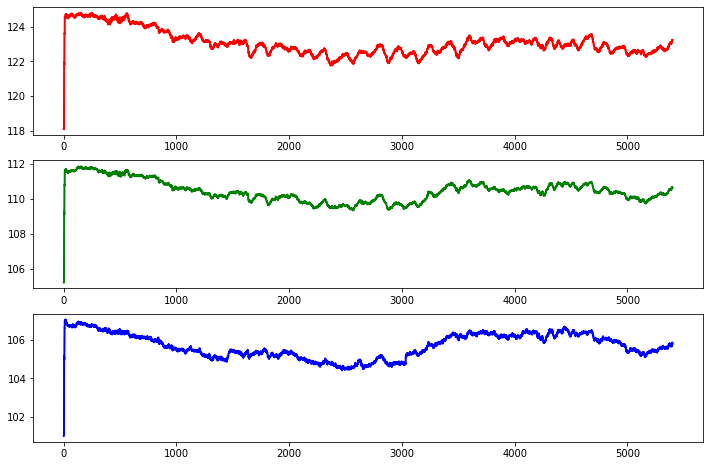

In [37]:
band = [42, 240]
fps = 30

r_signal = []
g_signal = []
b_signal = []
prev_bbox = [0,0,10,10]
curr_bbox = [0,0,10,10]
track_toler = 1
detect_th=0.5
# 얼굴검출 opencv 사용 
#detector = cv2.dnn.readNetFromTensorflow('model/face_detector.pb','model/face_detector.pbtxt')

times=[]
group=[]

#cap = cv2.VideoCapture(1) # 0: 내장캠 1: 외부캠
#time.sleep(2)

file_num=1
file_path="D:\\prlab\\ysg\\rppg\\RPPG-Deepfake_Detection\\ROI\\"+str(file_num)
file_list=glob.glob(os.path.join(file_path,"*.png"))
file_list = natsort.natsorted(file_list,reverse=False)

# mopohlogy 커널생성
#kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))

try:
    for file in file_list:
#         # group 설정
#         g=file.split('\\')[-1].split('_')[1]
#         group.append(g)
#         # time 설정
#         t=file.split('\\')[-1].split('_')[-1][:-4]
#         times.append(t)
        # 프레임(img) 가져오기
        print("img path: ",file)
        frame = cv2.imread(file, cv2.IMREAD_COLOR)
#         ycbcr_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2YCR_CB)
        
#         # 1. 팔영역 ROI찾기
#         find_arm(ycbcr_frame)
        
#         # 2. # ROI 이미지 크롭, 팔빼고 black처리
#         ROI=list(zip(ROI_x,ROI_y))
#         for i in range(min(ROI_x),max(ROI_x),1):
#             for j in range(min(ROI_y),max(ROI_y),1):
#                 if (i,j)not in ROI:
#                     frame[i][j]=0
                    
#         # 3. arm이미지 추출
#         arm=RGB_frame[min(ROI_x):max(ROI_x)+1,min(ROI_y):max(ROI_y)+1]
        
        # remote-PPG 신호 추출하기
        b, g, r = cv2.split(frame)
        r_mean = np.mean(r)
        g_mean = np.mean(g)
        b_mean = np.mean(b)
        # 각 신호를 담을 list
        r_signal.append(r_mean)
        g_signal.append(g_mean)
        b_signal.append(b_mean)

#         # 얼굴 검출 시각화하기
#         cv2.rectangle(frame, (curr_bbox[0], curr_bbox[1]), (curr_bbox[2], curr_bbox[3]), (0,0,255), 2)
#         cv2.imshow('frame', frame)
        if cv2.waitKey(1) == 27:
            break
            
    
finally:
    cv2.destroyAllWindows()
    print("==================================================!!!finish!!!=================================================")

plt.figure(figsize=(12, 8))
plt.subplot(3,1,1)
plt.plot(r_signal, 'r', linewidth=2)
plt.subplot(3,1,2)
plt.plot(g_signal, 'g', linewidth=2)
plt.subplot(3,1,3)
plt.plot(b_signal, 'b', linewidth=2)
plt.show()

pulse length:  (5401,)


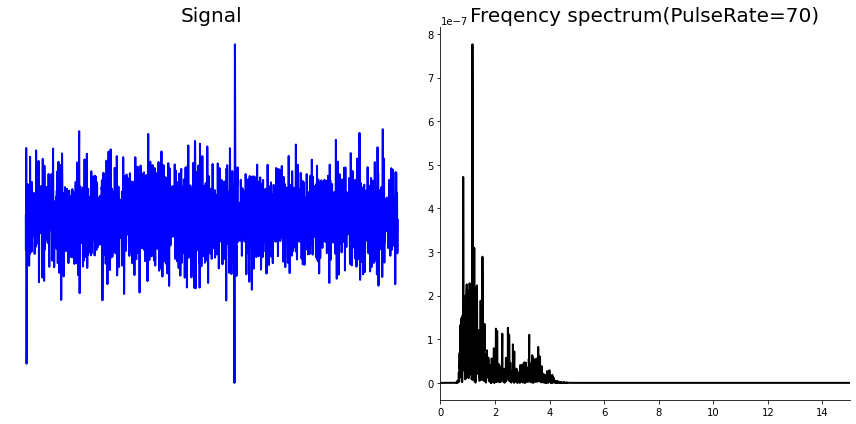

In [38]:
# CHROM 신호 추출
# chrom이란 움직임에 더 강인하게 하는것.
# 움직임은 r,g,b동일하게발생/ pulse는 r,g,b각각 다름
# 이를 이용해 움직임은 제거하고 pulse만 남기도록.

#보통 신호는 g,r,b순으로 잘보인다. 
# 심박수를 더 잘보이게 하기위한 후처리
raw_signal = np.array([r_signal, g_signal, b_signal]).transpose() # 1.세개의 신호를 하나로, 하나의신호화
detrended = detrend_signal(raw_signal, fps) # 2.추세제거
detrended = detrended.transpose()
# 3. 2차원으로 prediction  , 수식에 대해서는 자세히 이해 x
X = 3 * detrended[0] - 2 * detrended[1] # 4. detrend [] > 0: r, 1: g, 2: b
Y = 1.5 * detrended[0] + detrended[1] - 1.5 * detrended[2]
# 5. bandpass filtering
Xf = filter_bandpass(X, fps, band)
Yf = filter_bandpass(Y, fps, band)
alpha = np.std(Xf) / np.std(Yf)
# 6. pulse 신호로 계산
pulse = Xf - alpha * Yf
print("pulse length: ",pulse.shape)

# 심박수 (심장) / '맥박수' (혈관) >> 우리는 맥박수를 보는것.
# 맥박수 계산하는 방법
# 1) 시계열 도메인에서 PPI(peak-to-peak interval) 계산  ==> instant pulse-rate
# 2) 주파수 도메인에서 maximum power band 검출 ==> average pulse-rate


# 주파수 스펙트럼 계산
# 실시간에서는 실시간 fs를 계산해서 파라미터로 넣어줘야함
f, psd = signal.periodogram(pulse, fs=30, window='hann')
max_band = np.argmax(psd)
pr = int(f[max_band] * 60) #분당맥박수
pr = min(max(pr, band[0]), band[1])


plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(pulse, 'b', linewidth=2)    
plt.axis('off')
plt.title('Signal', fontsize=20)

ax = plt.subplot(1,2,2)
plt.plot(f, psd, 'k', linewidth=2)    
plt.xlim([0, 15])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Freqency spectrum(PulseRate={})'.format(pr), fontsize=20)

plt.tight_layout()
plt.show()

# file_num=subject
# save_path='D:\\prlab\\ysg\\rppg\\rppg_HRV\\data\\rppg\\'
# f = open(save_path+'rppg'+str(file_num)+'.csv', 'w', newline='')
# wr = csv.writer(f)
# wr.writerow(pulse)
# wr.writerow(times)
# wr.writerow(group)
# f.close()

In [77]:
from sklearn.preprocessing import MinMaxScaler
import heartpy as hp
arm_pulse=pulse

def normalization(ppg_data):
    ppg_data=np.array(ppg_data)
    # MinMaxScaler객체 생성
    scaler = MinMaxScaler()
    # MinMaxScaler 로 데이터 셋 변환. fit() 과 transform() 호출.
    scaler.fit(ppg_data.reshape(len(ppg_data),1))
    ppg_scaled = scaler.transform(ppg_data.reshape(len(ppg_data),1))
    #print(type(ppg_scaled))
    #print(ppg_scaled.shape) > len(ppg_data),1
#     plt.plot(ppg_scaled)
#     plt.show()
    return ppg_scaled.reshape(len(ppg_data))

def preprocessing(ppg_data, cut_l, cut_h, sr):
    filtered = hp.filter_signal(ppg_data, cutoff=cut_l, sample_rate=sr, order=3, filtertype='lowpass')
    filtered = hp.filter_signal(filtered, cutoff=cut_h, sample_rate=sr, order=3, filtertype='highpass')
    return filtered

face_pulse_=normalization(face_pulse)
arm_pulse_=preprocessing(arm_pulse,1.5,0.8,30)
arm_pulse_=normalization(arm_pulse_)

face_f, face_psd = signal.periodogram(face_pulse_, fs=30, window='hann')
max_band = np.argmax(face_psd)
pr = int(face_f[max_band] * 60) #분당맥박수
face_pr = min(max(pr, band[0]), band[1])

arm_f, arm_psd = signal.periodogram(arm_pulse_, fs=30, window='hann')
max_band = np.argmax(arm_psd)
pr = int(arm_f[max_band] * 60) #분당맥박수
arm_pr = min(max(pr, band[0]), band[1])

print(face_pr,arm_pr)

78 70


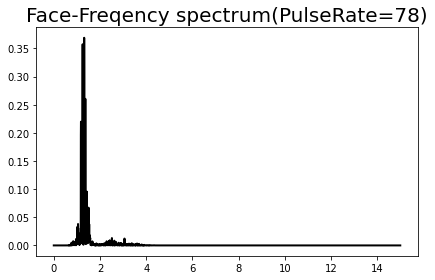

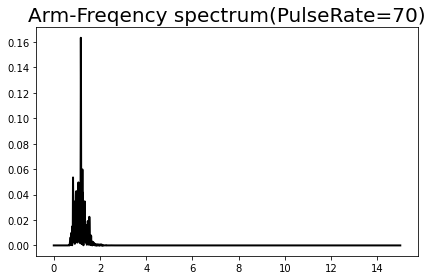

In [84]:
plt.plot(face_f, face_psd, 'k', linewidth=2) 
plt.title('Face-Freqency spectrum(PulseRate={})'.format(face_pr), fontsize=20)
plt.tight_layout()
plt.show()


plt.plot(arm_f, arm_psd, 'k', linewidth=2) 
plt.title('Arm-Freqency spectrum(PulseRate={})'.format(arm_pr), fontsize=20)
plt.tight_layout()
plt.show()

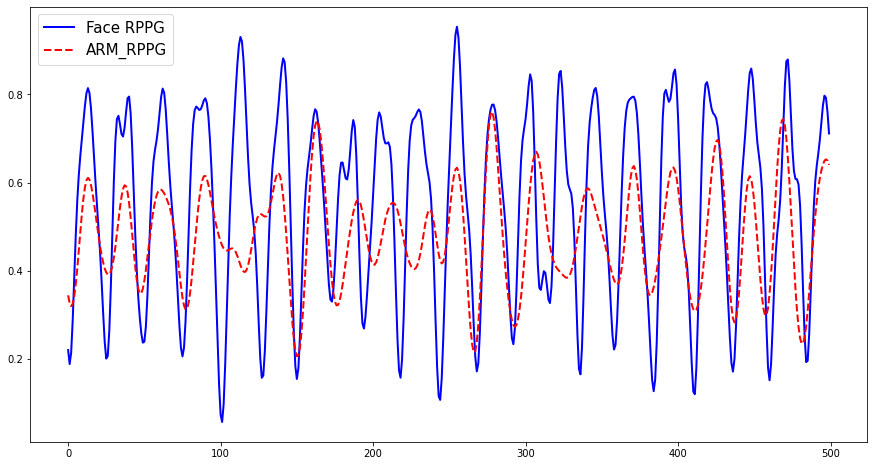

In [82]:
plt.figure(figsize=(15, 8))
plt.plot(face_pulse_[1500:2000], 'b', linewidth=2,label='Face RPPG')
plt.plot(arm_pulse_[1500:2000], 'r', linestyle='--',linewidth=2,label='ARM_RPPG') 
plt.legend(fontsize=15)
plt.show()